### Modularity clustering on undirected graphs
This code follows from Mark Newman 2006 (publications) 

We start with some basic imports:

In [2]:
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt

Next, create a symmetric matrix with two random communities for testing purposes:


In [3]:
def sym_rand_community(n, m, pn = 0.9, pm = 0.9, pnm = 0.1):
    mat = np.zeros((n + m, n + m))
    for i in range(0, n):
        for j in range(0, i):
            mat[i, j] = 1 if np.random.random_sample() < pn else 0
            mat[j, i] = mat[i, j]
    for i in range(n, n + m):
        for j in range(n, i):
            mat[i, j] = 1 if np.random.random_sample() < pm else 0
            mat[j, i] = mat[i, j]
    for i in range(0, n):
        for j in range(n, n + m):
            mat[i, j] = 1 if np.random.random_sample() < pnm else 0
            mat[j, i] = mat[i, j]
    return mat


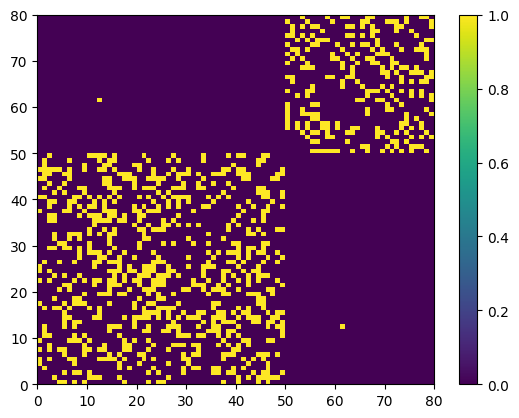

In [4]:
adj = sym_rand_community(50, 30, 0.3, 0.3, 0.001)

plt.pcolormesh(adj)
plt.colorbar()

## Now we try to implement the code in the paper (2006a). 

First calculate the modularity matrix:

In [5]:
def calculate_modularity_mat(adj): 
    # initialize matrix
    n = np.shape(adj)[0]
    mod_mat = np.zeros((n, n))

    # calculate total edges in matrix:
    m2 = np.sum(adj) # actually twice the number of edges!
    deg = np.zeros(n)
    for i in range(n):
        deg[i] = np.sum(adj[i, :])
    
    mod_mat = adj - np.outer(deg, deg) / m2
    
    return mod_mat

In [6]:
test = np.array([1, 2, 3])
res = np.outer(test, test)
res

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [7]:
mod_mat = calculate_modularity_mat(adj)

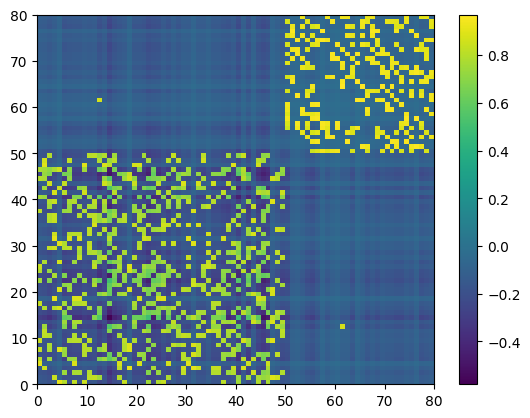

In [8]:
# visualization of modularity matrix
plt.pcolormesh(mod_mat)
plt.colorbar()

Next, calculate the eigenvalues and eigenvectors. Then split into communities based on the signs of the largest eigenvector. 

In [9]:
ews, evs = np.linalg.eig(mod_mat)

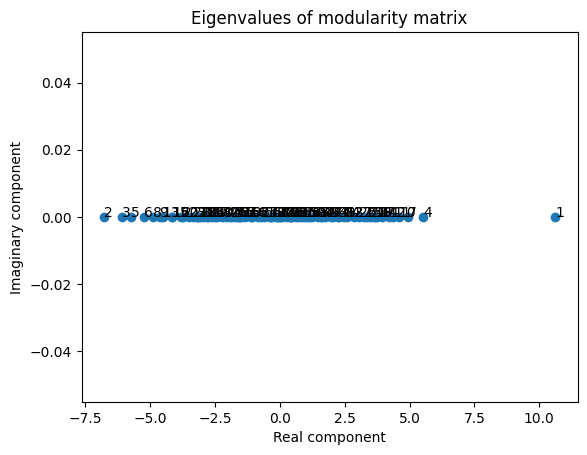

In [10]:
# plot eigenvalues of modularity matrix
fig, ax = plt.subplots()
ax.scatter(ews.real, ews.imag)
ax.set_title("Eigenvalues of modularity matrix")
ax.set_xlabel("Real component")
ax.set_ylabel("Imaginary component")

# optional: label each eigenvalue (sorted from largest magnitude to smallest)
n = np.size(ews)
for i in range(n):
    ax.annotate(i + 1, (ews[i].real, ews[i].imag))

Next, we get the indices of the two communities and then visualize them. 

In [11]:
# get indices
s = np.zeros(n)
for i in range(n):
    s[i] = 1 if evs[i, 0] > 0 else -1 
idx1 = s == 1
idx2 = s == -1

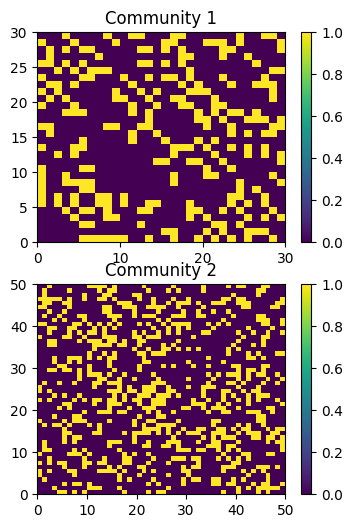

In [12]:
# note here index can be for any group
fig, axs = plt.subplots(2, figsize = (4, 6))

ax0 = axs[0].pcolormesh(adj[idx1, :][:, idx1])
axs[0].set_title("Community 1")

ax1 = axs[1].pcolormesh(adj[idx2, :][:, idx2])
axs[1].set_title("Community 2")

fig.colorbar(ax0)
fig.colorbar(ax1)

Finally, calulate the modularity:

In [13]:
Q = 1/(2*(np.sum(adj))) * np.dot(s, np.dot(mod_mat, s))
print(Q)

0.37797338384495316


So we should be able to write a complete function to split a graph into two commmunities using modularity:

In [14]:
def modularity_split(adj):
    # calculates a graph partitioning using modularity on a symmectric graph

    # calulate modularity matrix
    n = np.shape(adj)[0]

    B = np.zeros((n, n))

    # calculate total edges in matrix:
    m2 = np.sum(adj) # actually twice the number of edges!
    deg = np.zeros(n)
    for i in range(n):
        deg[i] = np.sum(adj[i, :])
    
    B = adj - np.outer(deg, deg) / m2

    # get eigenvectors
    ews, evs = np.linalg.eig(B)
    
    # get signs
    s = np.sign(evs[:, 0])

    # calculate modularity
    Q = np.dot(s, np.dot(B, s)) / (2 * m2)
    return s, Q

In [15]:
modularity_split(adj)

(array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.]),
 np.float64(0.37797338384495316))

Next, consider splitting into multiple communities. Newman proposes a hierarchical splitting, in which comunities are repeatedly split until the modularity no longer increases. 

We first need to get the modularity matrix for a subgroup:

In [16]:
def get_Bg(B, idx):
    n = np.shape(idx)[0]
    Bg = np.copy(B)

    for i in range(n):
        Bg[i, i] -= np.sum(B[i, idx]) 

    return Bg[idx, :][:, idx]

In [17]:
Bg = get_Bg(mod_mat, idx1)

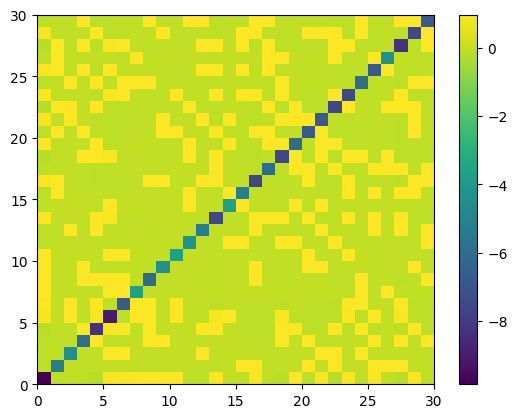

In [18]:
plt.pcolormesh(Bg)
plt.colorbar()

We then split this using spectral methods, as before. 

In [19]:
ewsg, evsg = np.linalg.eig(Bg)
ng = np.shape(Bg)[0]
sg = np.zeros(ng)
for i in range(ng):
    sg[i] = 1 if evsg[i, 0] > 0 else -1 
idx1g = sg == 1
idx2g = sg == -1

print(sg)

[ 1. -1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1.
  1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1.]


Finally, we can calculate the change in modularity if we apply this:

In [20]:
dQ = 1/(2*(np.sum(adj))) * np.dot(sg, np.dot(Bg, sg))
print(dQ)

-0.13899502471383976


So, we should only apply this split if the change in modularity is positive. We should be wary of numerical errors though. If we combine everything, we can write a complete function!

Start with some helper methods:

In [136]:
def get_Bg(B, idx):
    n = np.shape(idx)[0]
    Bg = np.copy(B)

    for i in range(n):
        Bg[i, i] -= np.sum(B[i, idx]) 

    return Bg[idx, :][:, idx]

def get_split(B, m2):
    ews, evs = np.linalg.eig(B)
    s = np.sign(evs[:, 0])
    dQ = np.dot(s, np.dot(B, s)) / (2 * m2)
    return s, dQ


And now for the hierarchical partitioning:

In [138]:
def modularity_partition(adj, tol = 0.0001):
    n = np.shape(adj)[0]
    
    # B = np.zeros((n, n)) # initialize modularity matrix
    labels = np.zeros(n) # track vertex labels
    Q = 0 # modularity
    last_comm = 0 # previously labeled community
    queue = [0]

    # calculate total edges in matrix:
    m2 = np.sum(adj) # actually twice the number of edges!
    deg = np.zeros(n)
    for i in range(n):
        deg[i] = np.sum(adj[i, :])

    B = adj - np.outer(deg, deg) / m2

    while(len(queue) > 0):

        comm = queue.pop(0)
        idx = labels == comm
        
        Bg = get_Bg(B, idx)
        s, dQ = get_split(Bg, m2)

        # help indexing
        if dQ > 0.001:
            labels[idx] += last_comm + (s + 3)/2
            queue.append(last_comm + 1)
            queue.append(last_comm + 2)

            last_comm = last_comm + 2
            Q = Q + dQ

        return s, Q